In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

In [88]:
pip install lckr_jupyterlab_variableinspector

Note: you may need to restart the kernel to use updated packages.


## Cleaning First Set of Data

Each set of data needs to be "cleaned" including standardizing to a reference sample, log2 transformation, normalizing by average, normalizing by slope, and imputation. This will make the data ready for proteomics analysis. I followed the steps outlined in Anguilan et al. (2020).

In [89]:
#CLEANING FIRST SET OF DATA

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('CC1 Raw Data.xlsx')

df = df.groupby('Description').sum().reset_index()

#Step 1: Standardize by Reference Sample
# Specify the range of columns to perform the division (columns 3 to 11)
columns_to_divide = df.iloc[:, 2:12]  
# Calculate the sum of each specified column
column_sums = columns_to_divide.sum()

# Calculate the sum of the final column
final_column_sum = column_sums.iloc[-1]  # Assuming the last column sum is what you refer to as the final column sum

# Divide each column sum by the sum of the final column
scaling_factor = column_sums / final_column_sum

#Divide each value by scaling factor
scaling_factor_df = columns_to_divide.divide(scaling_factor, axis=1)

#Step 2: Log2 Transformation
# Apply the log2 transformation to each element in the specified columns
log2_transformed_df = scaling_factor_df.applymap(lambda x: np.log2(x) if x > 0 else np.nan)

#Step 3: Normalize Data by Average
#Normalize the data by subtracting the mean
normalized_df = (log2_transformed_df - log2_transformed_df.mean())

#Step 4: Normalize Data by Slope
#Create a new column with all of the averages by row
normalized_df['Row_Average'] = normalized_df.mean(axis=1)

#Calculate correlation slopes
correlation_slopes = normalized_df.corr()['Row_Average'].drop('Row_Average')

# Divide each value in each row by its respective correlation coefficient and get rid of the average by row column
normalized_df = normalized_df.div(correlation_slopes, axis=1)
normalized_df = normalized_df.drop('Row_Average', axis=1)

#Step 5: Impute Data
# Define a function to replace NaN values with values drawn from a normal distribution
def replace_nan_with_normal(column):
    mean = column.mean()
    std = column.std()
    nan_count = column.isna().sum()
    if nan_count > 0:
        replacement_values = np.random.normal(mean, std, nan_count)
        column_nan_indices = column.isna()
        column.loc[column_nan_indices] = replacement_values
        return nan_count  # Return the count of replaced NaN values
    else:
        return 0  # Return 0 if no NaN values were replaced

# Apply the function to each column in the DataFrame
replaced_counts = normalized_df.apply(replace_nan_with_normal)

print("Number of replaced NaN values in each column:")
print(replaced_counts)

#Step 6: Add the Accession Number and Description columns back into the data frame
preprocessed_df_CC1 = pd.concat([df.iloc[:, :2], normalized_df], axis=1)
display(preprocessed_df_CC1)

# Specify the file path where you want to save the Excel file
excel_file_path = 'Preprocessed CC1.xlsx'

# Convert the DataFrame to an Excel file
preprocessed_df_CC1.to_excel(excel_file_path, index=False)

Number of replaced NaN values in each column:
Control 1      2
Control 2      1
Control 3      0
Control 4      1
Red Tide 1     0
Red Tide 2     0
Red Tide 3     2
Red Tide 4     1
Red Tide 5     2
Reference 1    1
dtype: int64


,Description,Accession,Control 1,Control 2,Control 3,Control 4,Red Tide 1,Red Tide 2,Red Tide 3,Red Tide 4,Red Tide 5,Reference 1
0,14-3-3 protein zeta/delta [Caretta caretta],XP_048697337.1,-2.780161,-2.671960,-1.870176,-1.628286,-2.423093,-2.135915,-1.190497,-2.067040,-2.398728,-2.310009
1,72 kDa type IV collagenase [Caretta caretta],XP_048672740.1,-0.268131,-0.612088,-1.176572,-1.097770,-0.078974,0.121288,-1.230201,-2.236613,-0.771329,-1.397068
2,"A Chain A, MYOGLOBIN",1LHS,-4.936600,-5.104898,-4.368287,-4.731287,-3.842361,-3.008289,-6.552861,-3.330846,-3.233779,-2.292577
3,A disintegrin and metalloproteinase with throm...,XP_048679217.1,-8.745823,-8.066206,-8.496372,-8.813228,-8.722752,-9.917998,-10.094825,-6.916542,-9.181706,-9.080507
4,C-type lectin-like [Caretta caretta],XP_048682979.1,-5.685077,-5.860943,-2.486964,-4.231720,-2.268914,-2.503947,-4.327568,-1.142191,-3.162511,-1.963551
...,...,...,...,...,...,...,...,...,...,...,...,...
261,vitelline membrane outer layer protein 1-like ...,XP_048673126.1XP_048690009.1,-0.146495,1.185867,0.853709,0.608181,1.939186,1.736319,-0.910943,1.513227,1.524238,0.996433
262,vitellogenin-1-like [Caretta caretta],XP_048718326.1,-4.666032,-0.625412,-6.032664,-5.657057,-5.667158,-2.432048,-6.981765,-5.112875,-6.284012,-0.542426
263,vitellogenin-2-like [Caretta caretta],XP_048716725.1XP_048718325.1,0.234967,3.497911,-0.941457,0.314358,-1.574786,2.316054,-1.188108,-1.064456,0.308972,3.435086
264,vitronectin [Caretta caretta],XP_048680272.1,4.267036,3.000097,3.022455,2.170572,3.500248,2.695535,2.990940,2.976752,3.652923,2.226099


## Cleaning Second Set of Data

This repeats the above code for the second set of data. 

In [90]:
#CLEANING SECOND SET OF DATA

# Read the Excel file into a pandas DataFrame
df_2 = pd.read_excel('CC2 Raw Data.xlsx')

#Add together duplicate rows
df_2 = df_2.groupby('Description').sum().reset_index()

#Step 1: Standardize by Reference Sample
# Specify the range of columns to perform the division (columns 3 to 11)
columns_to_divide = df_2.iloc[:, 2:12]  
# Calculate the sum of each specified column
column_sums = columns_to_divide.sum()

# Calculate the sum of the final column
final_column_sum = column_sums.iloc[-1]  # Assuming the last column sum is what you refer to as the final column sum

# Divide each column sum by the sum of the final column
scaling_factor = column_sums / final_column_sum

#Divide each value by scaling factor
scaling_factor_df = columns_to_divide.divide(scaling_factor, axis=1)

#Step 2: Log2 Transformation
# Apply the log2 transformation to each element in the specified columns
log2_transformed_df = scaling_factor_df.applymap(lambda x: np.log2(x) if x > 0 else np.nan)

#Step 3: Normalize Data by Average
#Normalize the data by subtracting the mean
normalized_df = (log2_transformed_df - log2_transformed_df.mean())

#Step 4: Normalize Data by Slope
#Create a new column with all of the averages by row
normalized_df['Row_Average'] = normalized_df.mean(axis=1)

#Calculate correlation slopes
correlation_slopes = normalized_df.corr()['Row_Average'].drop('Row_Average')

# Divide each value in each row by its respective correlation coefficient and get rid of the average by row column
normalized_df = normalized_df.div(correlation_slopes, axis=1)
normalized_df = normalized_df.drop('Row_Average', axis=1)

#Step 5: Impute Data
# Define a function to replace NaN values with values drawn from a normal distribution
def replace_nan_with_normal(column):
    mean = column.mean()
    std = column.std()
    nan_count = column.isna().sum()
    if nan_count > 0:
        replacement_values = np.random.normal(mean, std, nan_count)
        column_nan_indices = column.isna()
        column.loc[column_nan_indices] = replacement_values
        return nan_count  # Return the count of replaced NaN values
    else:
        return 0  # Return 0 if no NaN values were replaced

# Apply the function to each column in the DataFrame
replaced_counts = normalized_df.apply(replace_nan_with_normal)

print("Number of replaced NaN values in each column:")
print(replaced_counts)

#Step 6: Add the Accession Number and Description columns back into the data frame
preprocessed_df_CC2 = pd.concat([df_2.iloc[:, :2], normalized_df], axis=1)
display(preprocessed_df_CC2)

# Specify the file path where you want to save the Excel file
excel_file_path = 'Preprocessed CC2.xlsx'

# Convert the DataFrame to an Excel file
preprocessed_df_CC2.to_excel(excel_file_path, index=False)

Number of replaced NaN values in each column:
Control 5      1
Control 6      0
Control 7      0
Control 8      0
Red Tide 10    0
Red Tide 6     0
Red Tide 7     0
Red Tide 8     0
Red Tide 9     2
Reference 2    0
dtype: int64


,Description,Accession,Control 5,Control 6,Control 7,Control 8,Red Tide 10,Red Tide 6,Red Tide 7,Red Tide 8,Red Tide 9,Reference 2
0,72 kDa type IV collagenase [Caretta caretta],XP_048672740.1,-2.133663,-2.148410,-2.879709,-1.934149,-1.763190,-1.764549,-1.901253,-2.259455,-1.731558,-2.278058
1,"A Chain A, MYOGLOBIN",1LHS,-4.717385,-4.780653,-5.465985,-5.179918,1.632805,-2.474298,-1.065164,-0.521706,-3.608093,-2.042212
2,C-type lectin-like [Caretta caretta],XP_048682979.1,-2.463784,-2.183120,-1.503829,-2.139696,-3.709081,-1.954599,-0.188229,1.489502,-0.361142,-1.925766
3,C4b-binding protein-like [Caretta caretta],XP_048683028.1,2.381763,2.386909,2.390855,2.679201,4.261870,3.673361,4.303798,3.355177,3.135915,3.133907
4,CD276 antigen-like [Caretta caretta],XP_048709054.1,1.897518,3.096904,3.221019,2.839099,3.467068,2.389283,3.047511,2.011933,1.688141,2.617549
...,...,...,...,...,...,...,...,...,...,...,...,...
231,vitelline membrane outer layer protein 1-like ...,XP_048673126.1XP_048690009.1,0.185055,0.573828,0.737584,0.689884,0.834437,0.729233,1.207255,1.421934,0.356300,0.765175
232,vitellogenin-1-like [Caretta caretta],XP_048718326.1,0.061609,-3.953262,-4.793217,-4.477256,-4.838096,-1.796981,-3.781398,-4.531179,-2.951745,0.585792
233,vitellogenin-2-like [Caretta caretta],XP_048716725.1XP_048718325.1,2.246533,-0.288048,-1.386336,-0.081902,-1.221303,2.627309,-0.016370,-1.262303,1.217436,2.956621
234,vitronectin [Caretta caretta],XP_048680272.1,1.110325,2.690317,1.553859,2.270595,2.440132,2.084294,2.156768,2.086090,1.975778,2.109934


## Merge the DataFrames

We want all of the data in one data frame, so I have to merge them. The column that is common between both data sets is the "Description" column, which includes the identified protein names. We only want proteins that are found in all of the replicates, or at least most of them, so I merged using the "inner" part of the function to only keep those shared between the two data sets. 

In [91]:
#Step 7: Merge the DataFrames based on the shared column (Description)
merged_df = pd.merge(preprocessed_df_CC1, preprocessed_df_CC2, on='Description', how='inner')

# Specify the desired order of columns
desired_order = ['Accession_x', 'Description', 'Control 1', 'Control 2','Control 3','Control 4','Control 5','Control 6','Control 7','Control 8',\
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10','Reference 1', 'Reference 2']

# Reorder the columns
merged_df = merged_df[desired_order]

# Assuming df is your DataFrame and 'Description' is the column based on which you are dropping duplicates
initial_rows = merged_df.shape[0]

display(merged_df)
# Specify the file path where you want to save the Excel file
excel_file_path = 'Merged DF.xlsx'

# Convert the DataFrame to an Excel file
merged_df.to_excel(excel_file_path, index=False)

,Accession_x,Description,Control 1,Control 2,Control 3,Control 4,Control 5,Control 6,Control 7,Control 8,...,Red Tide 3,Red Tide 4,Red Tide 5,Red Tide 6,Red Tide 7,Red Tide 8,Red Tide 9,Red Tide 10,Reference 1,Reference 2
0,XP_048672740.1,72 kDa type IV collagenase [Caretta caretta],-0.268131,-0.612088,-1.176572,-1.097770,-2.133663,-2.148410,-2.879709,-1.934149,...,-1.230201,-2.236613,-0.771329,-1.764549,-1.901253,-2.259455,-1.731558,-1.763190,-1.397068,-2.278058
1,1LHS,"A Chain A, MYOGLOBIN",-4.936600,-5.104898,-4.368287,-4.731287,-4.717385,-4.780653,-5.465985,-5.179918,...,-6.552861,-3.330846,-3.233779,-2.474298,-1.065164,-0.521706,-3.608093,1.632805,-2.292577,-2.042212
2,XP_048682979.1,C-type lectin-like [Caretta caretta],-5.685077,-5.860943,-2.486964,-4.231720,-2.463784,-2.183120,-1.503829,-2.139696,...,-4.327568,-1.142191,-3.162511,-1.954599,-0.188229,1.489502,-0.361142,-3.709081,-1.963551,-1.925766
3,XP_048683028.1,C4b-binding protein-like [Caretta caretta],3.046959,3.867034,4.196444,3.630578,2.381763,2.386909,2.390855,2.679201,...,2.197760,2.573837,4.996730,3.673361,4.303798,3.355177,3.135915,4.261870,3.505632,3.133907
4,XP_048709054.1,CD276 antigen-like [Caretta caretta],3.951509,4.072524,3.634746,2.956497,1.897518,3.096904,3.221019,2.839099,...,2.217154,2.365261,1.810698,2.389283,3.047511,2.011933,1.688141,3.467068,2.857190,2.617549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,XP_048673126.1XP_048690009.1,vitelline membrane outer layer protein 1-like ...,-0.146495,1.185867,0.853709,0.608181,0.185055,0.573828,0.737584,0.689884,...,-0.910943,1.513227,1.524238,0.729233,1.207255,1.421934,0.356300,0.834437,0.996433,0.765175
205,XP_048718326.1,vitellogenin-1-like [Caretta caretta],-4.666032,-0.625412,-6.032664,-5.657057,0.061609,-3.953262,-4.793217,-4.477256,...,-6.981765,-5.112875,-6.284012,-1.796981,-3.781398,-4.531179,-2.951745,-4.838096,-0.542426,0.585792
206,XP_048716725.1XP_048718325.1,vitellogenin-2-like [Caretta caretta],0.234967,3.497911,-0.941457,0.314358,2.246533,-0.288048,-1.386336,-0.081902,...,-1.188108,-1.064456,0.308972,2.627309,-0.016370,-1.262303,1.217436,-1.221303,3.435086,2.956621
207,XP_048680272.1,vitronectin [Caretta caretta],4.267036,3.000097,3.022455,2.170572,1.110325,2.690317,1.553859,2.270595,...,2.990940,2.976752,3.652923,2.084294,2.156768,2.086090,1.975778,2.440132,2.226099,2.109934


## Internal Reference Scaling for Multiplexing

In order for the samples to be comparable across multiple plexes in proteomics, I must use an internal reference standard to scale all of the data so that their relative protein abundances can be compared properly. I did this by following steps outlines in Plubell et al. (2017). 

In [92]:
#Step 8: IRS FOR MULTIPLEXING

# Reset indices of both DataFrames if needed
merged_df.reset_index(drop=True, inplace=True)  # Reset index of merged_df
# Reset index of CC1_df and CC2_df if they are also merged into IRS_df
#CC1_df.reset_index(drop=True, inplace=True)
#CC2_df.reset_index(drop=True, inplace=True)

#Calculate Scaling Factor for IRS

# Calculate means between the two reference columns for each row (proteins)
means = merged_df[['Reference 1', 'Reference 2']].mean(axis=1)

# Add a new column containing the means
merged_df['Means'] = means

#Ensure all of the data is numeric
merged_df.iloc[:, 2:25] = merged_df.iloc[:, 2:25].apply(pd.to_numeric, errors='coerce')

# Divide Reference 1 and 2 by IRS Means and store the result in a new column
merged_df['Reference 1 SF'] = merged_df['Means'] / merged_df['Reference 1']
merged_df['Reference 2 SF'] = merged_df['Means'] / merged_df['Reference 2']

#display(merged_df)

#CC1
# Specify the column to divide by
divider_column_CC1 = 'Reference 1 SF'
# Specify the range of columns to perform the division 
columns_to_divide_CC1 = ['Control 1', 'Control 2', 'Control 3', 'Control 4', 'Red Tide 1', 'Red Tide 2', 'Red Tide 3', 'Red Tide 4', 'Red Tide 5']
# Divide each column by the reference
CC1_df = merged_df[columns_to_divide_CC1].div(merged_df[divider_column_CC1], axis=0)


#Add the Accession Number and Description columns back into the data frame
CC1_df[['Accession Number', 'Description']] = merged_df.iloc[:, :2]

# Specify the desired order of columns
desired_order = ['Accession Number', 'Description', 'Control 1', 'Control 2','Control 3','Control 4',
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5']

# Reorder the columns
CC1_df = CC1_df[desired_order]

#display(CC1_df)

#CC2
# Specify the column to divide by
divider_column_CC2 = 'Reference 2 SF'
# Specify the range of columns to perform the division 
columns_to_divide_CC2 = ['Control 5', 'Control 6', 'Control 7', 'Control 8', 'Red Tide 6', 'Red Tide 7', 'Red Tide 8', 'Red Tide 9', 'Red Tide 10']
# Divide each column by the reference
CC2_df = merged_df[columns_to_divide_CC2].div(merged_df[divider_column_CC2], axis=0)

#Add the Accession Number and Description columns back into the data frame
CC2_df[['Accession Number', 'Description']] = merged_df.iloc[:, :2]

# Specify the desired order of columns
desired_order = ['Accession Number', 'Description', 'Control 5','Control 6','Control 7','Control 8','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10']

# Reorder the columns
CC2_df = CC2_df[desired_order]

#display(CC2_df)

#Merge the DataFrames based on 'Description' column
IRS_df = pd.merge(CC1_df, CC2_df, on='Description', how='inner')

# Drop extra Accession Number from the DataFrame
IRS_df.drop(columns=['Accession Number_y'], inplace=True)

# Specify the desired order of columns
desired_order = ['Accession Number_x', 'Description', 'Control 1', 'Control 2','Control 3','Control 4','Control 5','Control 6','Control 7','Control 8',\
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10']

#Reorder the columns
IRS_df = IRS_df[desired_order]

display(IRS_df)

# Convert the DataFrame to an Excel file
excel_file_path = 'IRS_df.xlsx'
IRS_df.to_excel(excel_file_path, index=False)

,Accession Number_x,Description,Control 1,Control 2,Control 3,Control 4,Control 5,Control 6,Control 7,Control 8,Red Tide 1,Red Tide 2,Red Tide 3,Red Tide 4,Red Tide 5,Red Tide 6,Red Tide 7,Red Tide 8,Red Tide 9,Red Tide 10
0,XP_048672740.1,72 kDa type IV collagenase [Caretta caretta],-0.203855,-0.465360,-0.894527,-0.834615,-2.645139,-2.663421,-3.570024,-2.397798,-0.060042,0.092213,-0.935301,-1.700459,-0.586429,-2.187542,-2.357016,-2.801085,-2.146642,-2.185857
1,1LHS,"A Chain A, MYOGLOBIN",-5.221723,-5.399741,-4.620586,-5.004552,-4.444923,-4.504536,-5.150286,-4.880741,-4.064284,-3.182039,-6.931335,-3.523226,-3.420553,-2.331390,-1.003643,-0.491574,-3.399700,1.538499
2,XP_048682979.1,C-type lectin-like [Caretta caretta],-5.740309,-5.917884,-2.511125,-4.272832,-2.439848,-2.161910,-1.489219,-2.118909,-2.290956,-2.528273,-4.369612,-1.153288,-3.193235,-1.935610,-0.186400,1.475031,-0.357633,-3.673047
3,XP_048683028.1,C4b-binding protein-like [Caretta caretta],3.217548,4.083536,4.431388,3.833842,2.248416,2.253274,2.256999,2.529202,4.986506,5.366587,2.320806,2.717937,5.276480,3.467702,4.062843,3.167332,2.960345,4.023263
4,XP_048709054.1,CD276 antigen-like [Caretta caretta],4.124475,4.250787,3.793847,3.085909,1.814460,2.961345,3.080028,2.714826,2.313497,2.438744,2.314204,2.468794,1.889956,2.284699,2.914114,1.923866,1.614248,3.315306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,XP_048673126.1XP_048690009.1,vitelline membrane outer layer protein 1-like ...,-0.165726,1.341544,0.965781,0.688021,0.160761,0.498497,0.640756,0.599318,2.193756,1.964259,-1.030529,1.711879,1.724336,0.633501,1.048770,1.235266,0.309526,0.724894
205,XP_048718326.1,vitellogenin-1-like [Caretta caretta],116.727113,15.645534,150.915268,141.518961,1.664446,-106.802735,-129.495255,-120.959156,141.771654,60.840985,174.658328,127.905501,157.203093,-48.547885,-102.159594,-122.415963,-79.745409,-130.707717
206,XP_048716725.1XP_048718325.1,vitellogenin-2-like [Caretta caretta],0.252556,3.759755,-1.011932,0.337890,2.078364,-0.266485,-1.282559,-0.075771,-1.692669,2.489427,-1.277046,-1.144138,0.332101,2.430637,-0.015144,-1.167811,1.126303,-1.129880
207,XP_048680272.1,vitronectin [Caretta caretta],4.381352,3.080471,3.103428,2.228722,1.080579,2.618243,1.512230,2.209765,3.594021,2.767750,3.071069,3.056501,3.750787,2.028455,2.098987,2.030203,1.922847,2.374760


## Shapiro Wilk Test

This will test if the data across each row is normal.

In [93]:
#Step 9: Conduct Shapiro-Wilk Test to see if the data are normal
#A low p-value (typically below 0.05) suggests that the null hypothesis (the data is normally distributed) can be rejected, indicating non-normality. 

from scipy.stats import shapiro

# Select columns 3 to 18 that have the numeric data
data_shapiro = IRS_df.iloc[:, 2:]

# Iterate over each row of the subset DataFrame
for index, row in data_shapiro.iterrows():
    stat, p = shapiro(row)
    if p < 0.05:
        print(f'Row {index}: Statistic={stat:.3f}, p-value={p:.3f}')

Row 5: Statistic=0.803, p-value=0.002
Row 8: Statistic=0.766, p-value=0.001
Row 10: Statistic=0.766, p-value=0.001
Row 15: Statistic=0.790, p-value=0.001
Row 20: Statistic=0.840, p-value=0.006
Row 31: Statistic=0.515, p-value=0.000
Row 32: Statistic=0.880, p-value=0.026
Row 35: Statistic=0.877, p-value=0.024
Row 36: Statistic=0.881, p-value=0.028
Row 37: Statistic=0.896, p-value=0.048
Row 40: Statistic=0.891, p-value=0.040
Row 49: Statistic=0.838, p-value=0.006
Row 50: Statistic=0.884, p-value=0.030
Row 51: Statistic=0.876, p-value=0.023
Row 52: Statistic=0.811, p-value=0.002
Row 58: Statistic=0.870, p-value=0.018
Row 59: Statistic=0.843, p-value=0.007
Row 60: Statistic=0.890, p-value=0.039
Row 62: Statistic=0.791, p-value=0.001
Row 66: Statistic=0.832, p-value=0.005
Row 68: Statistic=0.853, p-value=0.010
Row 72: Statistic=0.881, p-value=0.027
Row 76: Statistic=0.798, p-value=0.001
Row 81: Statistic=0.843, p-value=0.007
Row 82: Statistic=0.879, p-value=0.025
Row 85: Statistic=0.887, p-

## Conduct F Test

This will test whether the data are homoscedastic across each row, which will determine whether I conduct an independent T test or a heteroscedastic T test. 

In [94]:
#Some of the data are not normal, so let us now conduct an F test for the data that are normal to see which T test is necessary

#Step 9: Conduct Bartlett's F-Test to see if the data are homoscedastic
from scipy.stats import bartlett

# Assuming your DataFrame is named df and the two groups are labeled as 'Group1' and 'Group2'
group1_data = IRS_df.filter(like='Control')  # Select columns containing 'Control' = Group 1
group2_data = IRS_df.filter(like='Red Tide')  # Select columns containing 'Red Tide' = Group 2

# Conduct Bartlett's test for homogeneity of variances for each group
statistic_group1, p_value_group1 = bartlett(*group1_data.values.T)
statistic_group2, p_value_group2 = bartlett(*group2_data.values.T)

# Print the result for Group 1
if p_value_group1 > 0.05:
    print("Control variances are homogeneous (p-value > 0.05)")
else:
    print("Control variances are not homogeneous (p-value <= 0.05)")

# Print the result for Group 2
if p_value_group2 > 0.05:
    print("Red Tide variances are homogeneous (p-value > 0.05)")
else:
    print("Red Tide variances are not homogeneous (p-value <= 0.05)")

Control variances are not homogeneous (p-value <= 0.05)
Red Tide variances are not homogeneous (p-value <= 0.05)


## Conditional Statement to Run a Heteroscedastic T Test or a Mann-Whitney U Test

This conditional statement will run a specific test across each line based on the following decision tree. It also adjusts each p-value using a Benjamini-Hochberg FDR correction.

![Decision Tree Describing which test is necessary to conduct](DecisionTree.jpg)

In [95]:
#Since the variances are not homogeneous, if the Shapiro Wilk test is (data are normal) we have to perform a heteroscedastic T test
#If the Shapiro Wilk Test is significant (data are non-normal), we have to perform a Mann-Whitney-U test

from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests

# Lists to store p-values and adjusted p-values and results
p_values = []
adjusted_p_values = []
results_list = []

# Assuming your DataFrame is named df
for index, row in IRS_df.iloc[:, 2:].iterrows():  # Exclude the first two columns
    group1_data = row[:8]  # First 8 values in the row
    group2_data = row[8:]  # Last 10 values in the row

    # Conduct Shapiro-Wilk test for each group
    stat_group1, p_value_group1 = shapiro(group1_data)
    stat_group2, p_value_group2 = shapiro(group2_data)

    # Perform the appropriate test based on the Shapiro-Wilk test result
    if p_value_group1 < 0.05 or p_value_group2 < 0.05:  # If either group is not normally distributed
        # Perform Mann-Whitney U test
        statistic, p_value = mannwhitneyu(group1_data, group2_data)
        test_type = 'Mann-Whitney U test'
    else:  # If both groups are normally distributed
        # Perform heteroscedastic t-test
        statistic, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
        test_type = 't-test'

    # Store p-values for FDR correction
    results_list.append({
        'Statistic': statistic,
        'P-value': p_value,
        'Test Type': test_type
    })

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_list)

# Apply FDR correction
reject, adjusted_p_values, _, _ = multipletests(results_df['P-value'], method='fdr_bh')

# Add adjusted p-values to the DataFrame
results_df['Adjusted P-value'] = adjusted_p_values

# Assuming your DataFrame is named df
for i, (index, row) in enumerate(IRS_df.iloc[:, 2:].iterrows()):  # Exclude the first two columns
    # Print only significant results after FDR correction
    if reject[i]:
        print(f"For row {index}: Adjusted p-value: {adjusted_p_values[i]}")

# Print the table
print(results_df)


For row 45: Adjusted p-value: 0.0139072480052571
For row 125: Adjusted p-value: 0.03821015585721468
For row 168: Adjusted p-value: 0.0368947888415964
For row 191: Adjusted p-value: 0.038950628818769865
     Statistic   P-value Test Type  Adjusted P-value
0    -0.404693  0.692012    t-test          0.925540
1    -3.014102  0.013730    t-test          0.220741
2    -1.811641  0.089683    t-test          0.450381
3    -1.544859  0.141982    t-test          0.618214
4     2.707569  0.020243    t-test          0.252299
..         ...       ...       ...               ...
204  -1.341103  0.202000    t-test          0.647944
205  -0.159227  0.875545    t-test          0.998847
206   0.621589  0.543778    t-test          0.874228
207  -0.338183  0.741256    t-test          0.944650
208  -1.202799  0.247967    t-test          0.664424

[209 rows x 4 columns]


In [96]:
#Find out which proteins are at these rows that are significant
# List of row indices
row_indices = [45, 125, 168, 191]

for row_index in row_indices:
    value_at_row = IRS_df.loc[row_index, 'Description']
    print(f"Protein at row {row_index}", value_at_row)
    
#Drop row 205 because it is strange
IRS_df.drop(205, inplace=True)


Protein at row 45 apolipoprotein E [Caretta caretta]
Protein at row 125 hepatocyte growth factor activator [Caretta caretta]
Protein at row 168 plastin-2 [Caretta caretta]
Protein at row 191 transferrin receptor protein 2 isoform X1 [Caretta caretta]


## Calculate Fold Change & Make Volcano Plot

Fold change will tell you the difference between the sample groups, taking into account the replicates. It does so by calculating a mean, and then you just find the difference to calculate fold change. Since the data were Log2 transformed, you subtract instead of divide to find fold change, and you this represents the log2 of the fold change, which is important for the volcano plot. A volcano plot is a common visualization technique in proteomics experiments because it graphs the log2 of the fold change (x axis) to the -log10 of the p-value (y-axis). The p-value represents the significance of the fold change, which is calculated through the statistical tests above (usually a t-test or something similar). A log2 Fold Change = 1 on the x-axis shows that a two-fold change has occured because of the logarithmic calculation. A p-value >= 1.3 on the y-axis shows significant proteins, since the -log10 of 0.05 is 1.3, and 0.05 is typically the alpha value for statistical analysis. 

In [97]:
# Calculate the average across columns 11 to 20 Red Tide 1- Red Tide 10
average_treatment = IRS_df.iloc[:, 10:20].mean(axis=1)

# Calculate the average across columns 3 to 10 Control 1 - Control 8
average_control = IRS_df.iloc[:, 2:10].mean(axis=1)

# Calculate the difference between these averages (since the data is log2 transformed already, this is the log2 fold change)
difference = average_treatment - average_control

# Create a new DataFrame to store the differences
difference_df = pd.DataFrame({'Log2 Fold Change': difference})

# Add the difference column to the existing DataFrame results_df
results_df = results_df.join(difference_df)

# Take the -log10 of 'Column1'
results_df['-Log10 P-value'] = -np.log10(results_df['Adjusted P-value'])

print(results_df)

     Statistic   P-value Test Type  Adjusted P-value  Log2 Fold Change  \
0    -0.404693  0.692012    t-test          0.925540          0.222527   
1    -3.014102  0.013730    t-test          0.220741          2.222462   
2    -1.811641  0.089683    t-test          0.450381          1.510202   
3    -1.544859  0.141982    t-test          0.618214          0.728204   
4     2.707569  0.020243    t-test          0.252299         -0.880467   
..         ...       ...       ...               ...               ...   
204  -1.341103  0.202000    t-test          0.647944          0.460447   
205  -0.159227  0.875545    t-test          0.998847               NaN   
206   0.621589  0.543778    t-test          0.874228         -0.478799   
207  -0.338183  0.741256    t-test          0.944650          0.142689   
208  -1.202799  0.247967    t-test          0.664424          0.452135   

     -Log10 P-value  
0          0.033605  
1          0.656118  
2          0.346420  
3          0.208861  
4

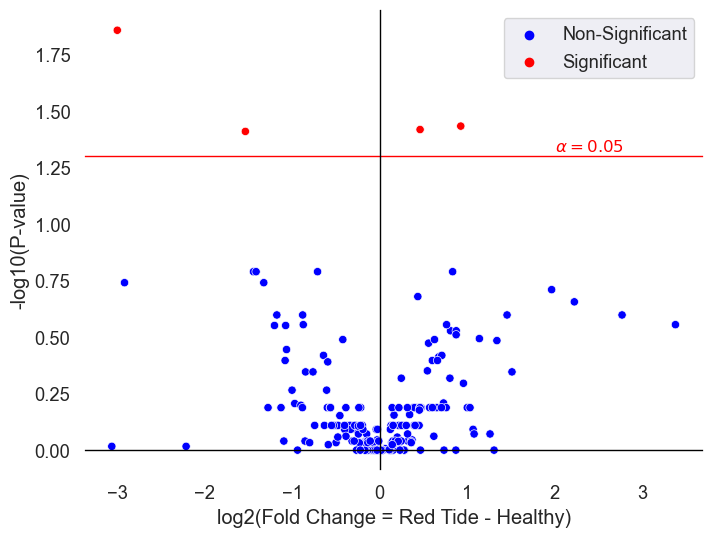

In [159]:
#Create Volcano Plot
# Plot Adjusted P vs Column2 as a scatterplot
#plt.scatter(results_df['Log2 Fold Change'], results_df['-Log10 P-value'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Log2 Fold Change', y='-Log10 P-value', data=results_df, 
                hue=np.where(results_df['-Log10 P-value'] > 1.3, 'Significant', 'Non-Significant'), palette=['blue', 'red'])

# Add labels and title
plt.xlabel('log2(Fold Change = Red Tide - Healthy)')
plt.ylabel('-log10(P-value)')
plt.axhline(y=1.3, color='red', linewidth=1) 
# Add label to the line with Greek letter alpha
plt.text(2, 1.32, r'$\alpha = 0.05$', color='red', fontsize=12)
plt.grid(False)
# Set background color to white
plt.gca().set_facecolor('white')
# Add x and y axis lines
plt.axhline(0, color='black', linewidth=1)  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=1)  # Add vertical line at x=0

# Save the figure to a JPEG file
plt.savefig('Volcano Plot.jpg', format='jpeg')

# Show the plot
plt.show()

## Create a Heat Map

A heat map will visually represent which proteins are upregulated or downregulated in within the two groups. The heatmap will allow you to visualize many of the proteins or all of the samples at one time so that you can see which may be different between the two. Warmer colors usually represent higher values above zero, so the proteins are upregulated within that sample, while cooler values usually represent lower values below zero, so the proteins are downregulated within that sample.

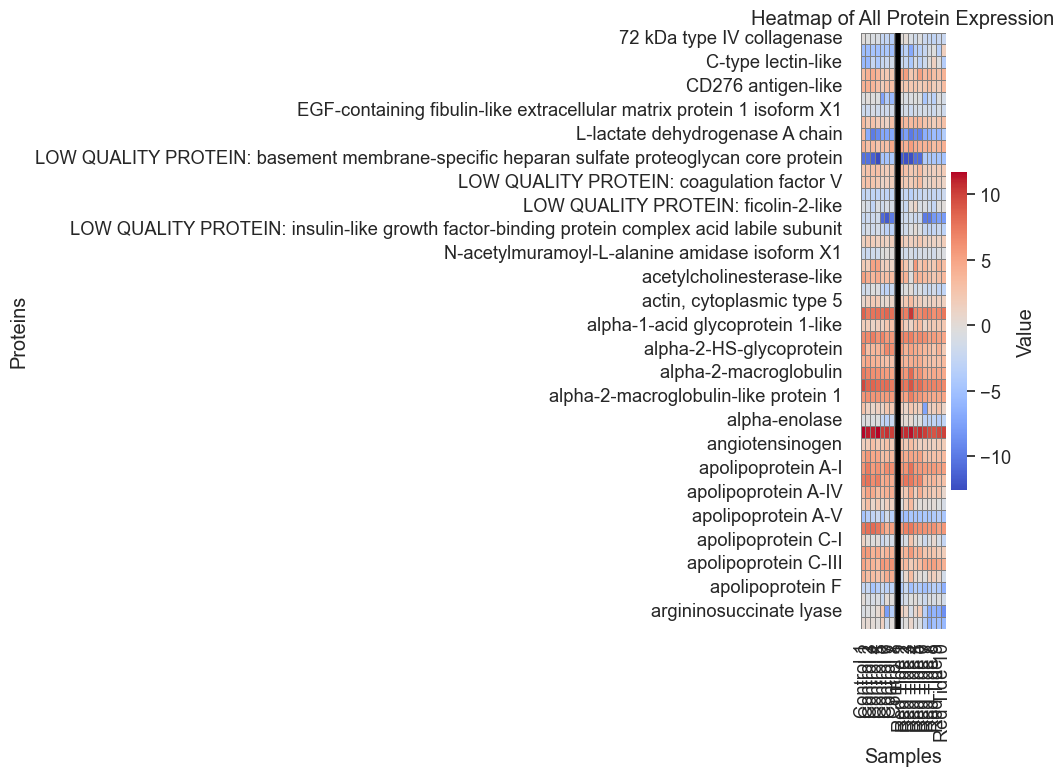

In [158]:
# Drop Accession Column
IRS_df_hm = IRS_df.drop(IRS_df.columns[0], axis=1)
# Make Description your index
IRS_df_hm.set_index('Description', inplace=True)
IRS_df_hm = IRS_df_hm.iloc[0:50,:]
# Drop certain words within the index
word_to_drop = '[Caretta caretta]'
IRS_df_hm.index = IRS_df_hm.index.str.replace(word_to_drop, '')

#Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(IRS_df_hm[['Control 1', 'Control 2','Control 3','Control 4','Control 5','Control 6','Control 7','Control 8',\
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10']], cmap='coolwarm', linewidths=0.5, linecolor='grey', cbar_kws={'label': 'Value'})

# Add labels and title
plt.xlabel('Samples')
plt.ylabel('Proteins')
plt.title('Heatmap of All Protein Expression')
# Draw a solid black line to divide up the x-axis
plt.axvline(x=8, color='black', linewidth=4) 

# Show the plot
plt.tight_layout()
plt.show()

In [153]:
rows_to_select = [45, 125, 168, 191]
sig_df = IRS_df.iloc[rows_to_select]

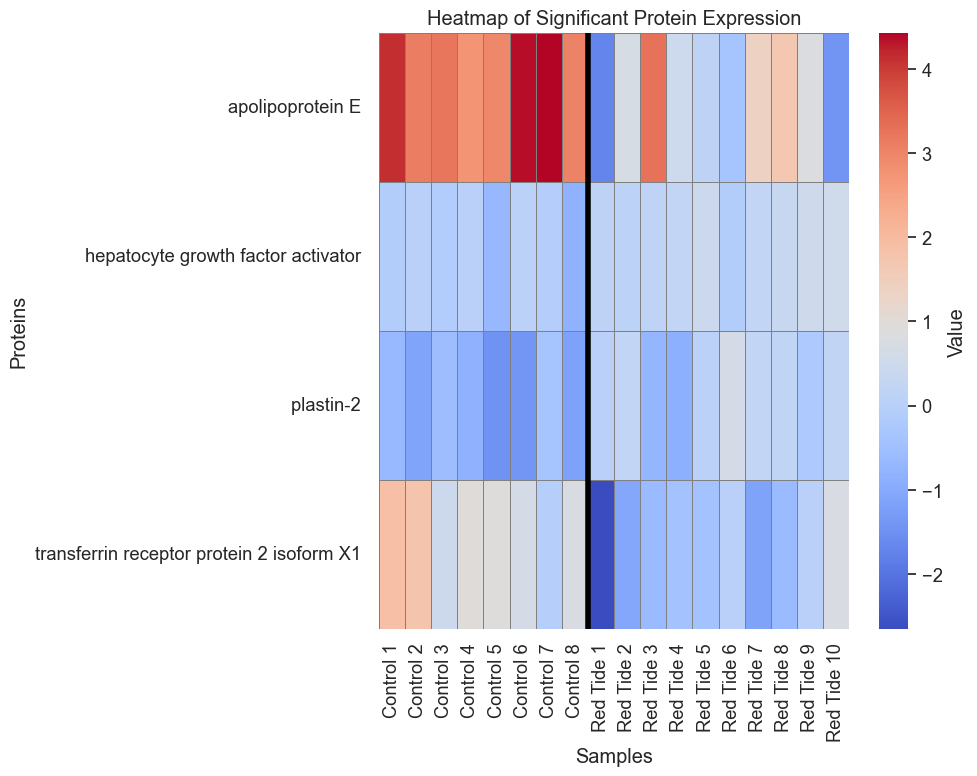

In [169]:
# Drop Accession Column
sig_df_numeric = sig_df.drop(IRS_df.columns[0], axis=1)
# Make Description your index
sig_df_numeric.set_index('Description', inplace=True)
# Drop certain words within the index
word_to_drop = '[Caretta caretta]'
sig_df_numeric.index = sig_df_numeric.index.str.replace(word_to_drop, '')

#Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sig_df_numeric[['Control 1', 'Control 2','Control 3','Control 4','Control 5','Control 6','Control 7','Control 8',\
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10']], cmap='coolwarm', linewidths=0.5, linecolor='grey', cbar_kws={'label': 'Value'})

# Add labels and title
plt.xlabel('Samples')
plt.ylabel('Proteins')
plt.title('Heatmap of Significant Protein Expression')
# Draw a solid black line to divide up the x-axis
plt.axvline(x=8, color='black', linewidth=4) 

# Save the figure to a JPEG file
plt.savefig('Heatmap Significant Proteins.jpg', format='jpeg', bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

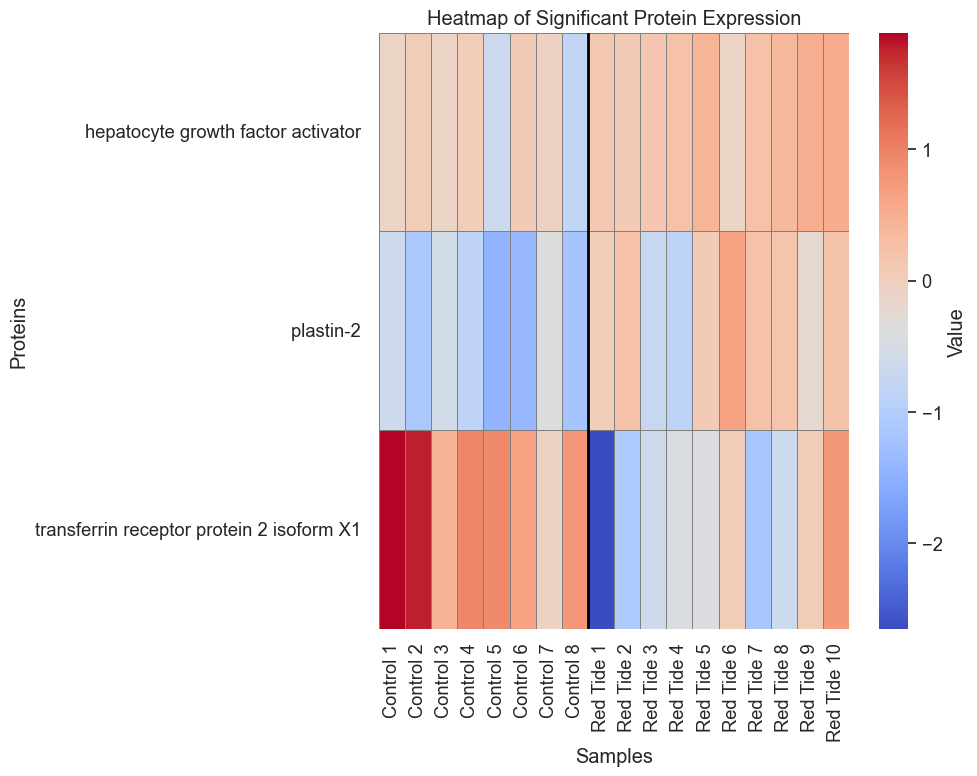

In [171]:
rows_to_select = [125, 168, 191]
low_df = IRS_df.iloc[rows_to_select]

# Drop Accession Column
low_df_numeric = low_df.drop(IRS_df.columns[0], axis=1)
# Make Description your index
low_df_numeric.set_index('Description', inplace=True)
# Drop certain words within the index
word_to_drop = '[Caretta caretta]'
low_df_numeric.index = low_df_numeric.index.str.replace(word_to_drop, '')

#Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(low_df_numeric[['Control 1', 'Control 2','Control 3','Control 4','Control 5','Control 6','Control 7','Control 8',\
                'Red Tide 1', 'Red Tide 2','Red Tide 3','Red Tide 4','Red Tide 5','Red Tide 6','Red Tide 7','Red Tide 8','Red Tide 9',\
                 'Red Tide 10']], cmap='coolwarm', linewidths=0.5, linecolor='grey', cbar_kws={'label': 'Value'})

# Add labels and title
plt.xlabel('Samples')
plt.ylabel('Proteins')
plt.title('Heatmap of Significant Protein Expression')
# Rotate y-axis labels horizontally
plt.yticks(rotation=0)
# Draw a solid black line to divide up the x-axis
plt.axvline(x=8, color='black', linewidth=2)  # Change the x value as needed

# Save the figure to a JPEG file
plt.savefig('Heatmap 3 Proteins.jpg', format='jpeg', bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

### Sources

Aguilan, J. T., Kulej, K., & Sidoli, S. (2020). Guide for protein fold change and p-value calculation for non-experts in proteomics. Molecular Omics, 16(6), 573-582.

Plubell, D. L., Wilmarth, P. A., Zhao, Y., Fenton, A. M., Minnier, J., Reddy, A. P., ... & Pamir, N. (2017). Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), 873-890.